# Text-Based Ad Feedback Topic Modeling & Hyperparameter Tuning

### TOC
* [Step 1: Load Data & Packages](#1)
* [Step 2: Initial Topic Model - LDA](#2)
* [Step 3: Hyperparameter Tuning - LDA](#3)
* [Step 4: Initial Topic Model - NMF](#4)
* [Step 5: Hyperparameter Tuning - NMF](#5)
* [Step 6: Final Model Selection](#6)

## Step 1: Load Data & Packages<a class="anchor" id="1"></a>

In [1]:
#Import Packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.sklearn
from sklearn.model_selection import RandomizedSearchCV

#Additional packages
import warnings
warnings.filterwarnings('ignore')
import qgrid
def view(df_test):
    return qgrid.show_grid(df_test, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

In [2]:
#Open data

#processed_df
processed_df = pd.read_pickle('../Datafiles/processed_df.pkl')

#message train & test
df_train = pd.read_pickle('../Datafiles/df_train.pkl')
df_test = pd.read_pickle('../Datafiles/df_test.pkl')

#tfidf train
open_file = open('../Datafiles/tfidf_train.pkl', "rb")
tfidf_train = pickle.load(open_file)
open_file.close()

#tfidf test
open_file = open('../Datafiles/tfidf_test.pkl', "rb")
tfidf_test = pickle.load(open_file)
open_file.close()

#tfidf feature names
open_file = open('../Datafiles/tfidf_feature_names.pkl', "rb")
tfidf_feature_names = pickle.load(open_file)
open_file.close()

## Step 2: Initial Topic Model - LDA<a class="anchor" id="2"></a>

#### Create Latent Dirichlet Allocation (LDA) Topic Model<br>
<i>LDA is an unsupervised Machine Learning model used for topic modeling in natural language processing based on Dirichlet distribution.</i> https://medium.com/analytics-vidhya/topic-modelling-using-latent-dirichlet-allocation-in-scikit-learn-7daf770406c4 <br>
LDA topic model code & pyLDAvis code adapted from
[Towards Data Science article posted by Kamil Mysiak](https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28)
<br>

* The following parameters may be optimized:
    * n_components: Number of topics to generate
        * Feedback is based on 3 ads, so set n_components as 6 (2 per ad) to start
    * learning_method: setting to online (online variational Bayes method) which may be faster
    * max_iter: This is somewhat arbitrary initially. Will set to 250 based on num of words in corpus
    * random_state: 22 for my favorite number :)
    

In [3]:
#LDA (Latent dirichlet allocation) Topic Modelling

#initial LDA model fit to tf_train generated above
lda_model = LatentDirichletAllocation(n_components=6,learning_method='online', 
                                      max_iter=250, random_state=22).fit(tfidf_train)

#Function to display topics with top 10 words included in each topic
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

display_topics(lda_model, tfidf_feature_names, no_top_words)

Topic 0:
company teen lie vape target harmful juul product young try
Topic 1:
smoke safe tell vape stop danger people inform inhale harmless
Topic 2:
health risk disease vape high germ ingredient get spread increase
Topic 3:
vape stop damage virus lung dangerous susceptible make vulnerable people
Topic 4:
bad vape chemical body harm know good harmful people contain
Topic 5:
immune weaken vape virus sick break fight easy likely body


In [4]:
#Add topic models to df to review by ad -- training set

#generates topic values 
lda_topic_values_train = lda_model.transform(tfidf_train)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_train['lda_topics'] = lda_topic_values_train.argmax(axis=1)

#Adds labels to the 'lda_topics' values for readibility
#With final model, may want to translate these into more readable topics
message_remap = {0: '0: company teen lie vape target harmful juul product young try', 
                 1: '1: smoke safe tell vape stop danger people inform inhale harmless', 
                 2: '2: health risk disease vape high germ ingredient get spread increase', 
                 3: '3: vape stop damage virus lung dangerous susceptible make vulnerable people', 
                 4:'4: bad vape chemical body harm know good harmful people contain', 
                 5: '5: immune weaken vape virus sick break fight easy likely body'}
df_train['lda_topics'] = df_train['lda_topics'].map(message_remap)

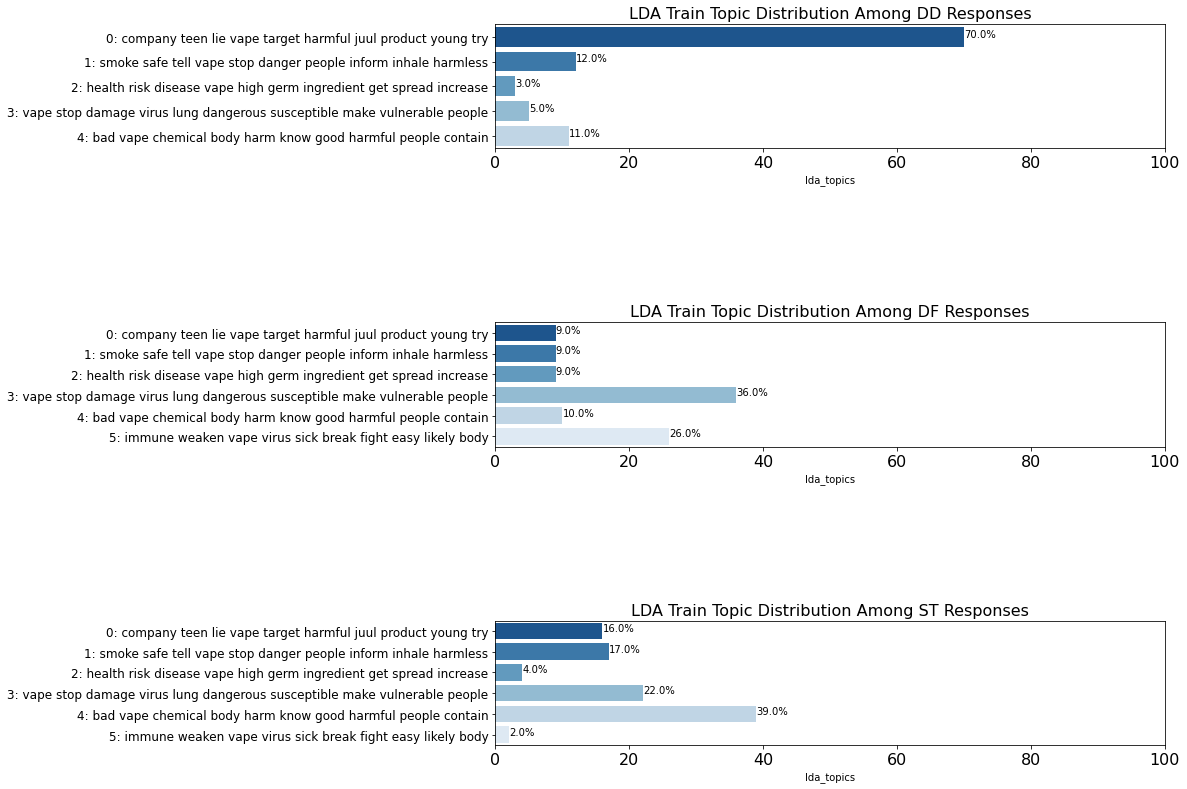

In [5]:
#Function for bar charts
def topic_bars(df,ad,topic_var,title):
    lda_x = round(df[df['Ad']==ad][topic_var].value_counts(normalize=True).sort_index(),2)*100
    lda_y = lda_x
    sns.set_palette("Blues_r")
    ax = sns.barplot(x=lda_x, y=lda_y.index)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format((p.get_x() + p.get_width() + 0.02))
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    return ax, plt.title(title + " Topic Distribution Among "+ad +" Responses", fontsize=16),plt.yticks(fontsize=12),plt.xticks(fontsize=16),plt.xlim([0,100])

#View topic distributions - LDA
plt.figure(figsize=(12,16))

#DD
plt.subplot(6,1,1)
topic_bars(df_train,'DD','lda_topics','LDA Train')

#DF
plt.subplot(6,1,3)
topic_bars(df_train,'DF','lda_topics','LDA Train')

#ST
plt.subplot(6,1,5)
topic_bars(df_train,'ST','lda_topics','LDA Train')
plt.show()

In [6]:
#Add topic models to df to review by ad -- test set

#generates topic values 
lda_topic_values_test = lda_model.transform(tfidf_test)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_test['lda_topics'] = lda_topic_values_test.argmax(axis=1)

#Adds labels to the 'lda_topics' values for readibility
#With final model, may want to translate these into more readable topics
message_remap = {0: '0: company teen lie vape target harmful juul product young try', 
                 1: '1: smoke safe tell vape stop danger people inform inhale harmless', 
                 2: '2: health risk disease vape high germ ingredient get spread increase', 
                 3: '3: vape stop damage virus lung dangerous susceptible make vulnerable people', 
                 4:'4: bad vape chemical body harm know good harmful people contain', 
                 5: '5: immune weaken vape virus sick break fight easy likely body'}
df_test['lda_topics'] = df_test['lda_topics'].map(message_remap)

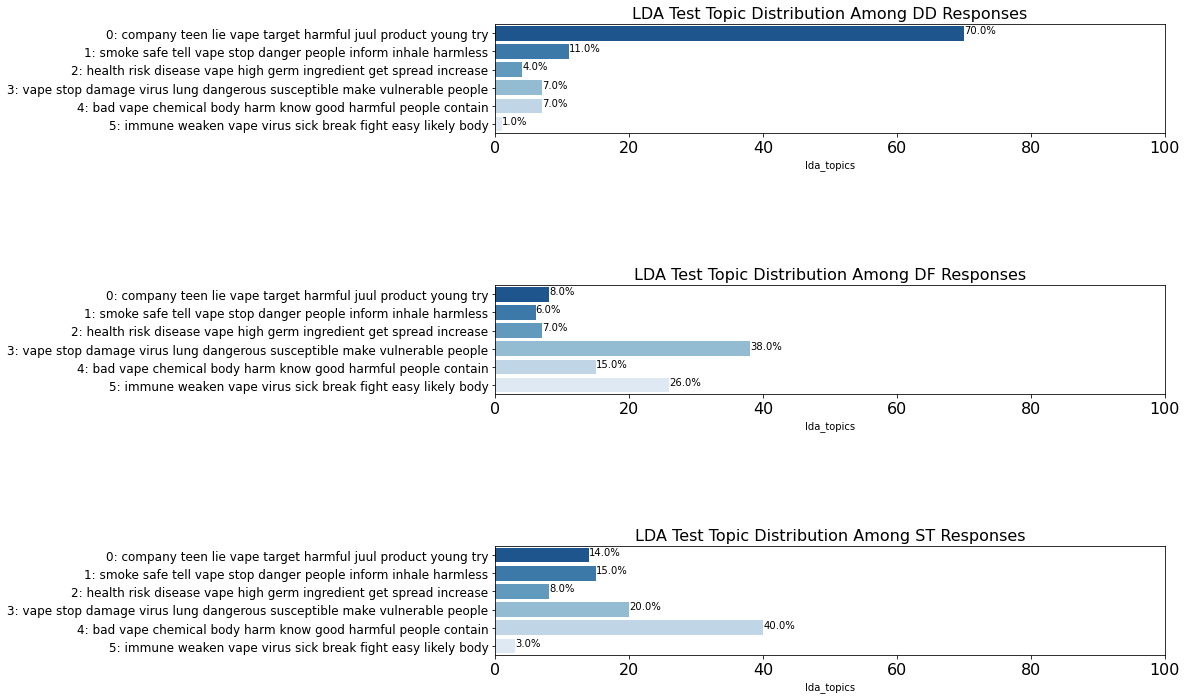

In [7]:
#View topic distributions - LDA Test
plt.figure(figsize=(12,14))

#DD
plt.subplot(6,1,1)
topic_bars(df_test,'DD','lda_topics','LDA Test')

#DF
plt.subplot(6,1,3)
topic_bars(df_test,'DF','lda_topics','LDA Test')

#ST
plt.subplot(6,1,5)
topic_bars(df_test,'ST','lda_topics','LDA Test')
plt.show()

### Visualization of LDA Model on Test Set

In [8]:
#Instantiate vectorizer just to be used in LDA visualization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, use_idf=True)
#Need to fit tfidf again in order to run pyLDAvis
tfidf = tfidf_vectorizer.fit_transform(processed_df['Lemmas_String'].values.astype('U'))

#Run pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tfidf_test, tfidf_vectorizer,mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       1.465019 -47.625065       1        1  22.103519
3      54.854797 -36.476795       2        1  19.778414
4      32.212929 -61.444572       3        1  18.546651
5       5.111096 -14.110332       4        1  15.041225
1      26.350170 -33.374702       5        1  13.582420
2      38.109818  -7.222781       6        1  10.947772, topic_info=        Term       Freq      Total Category  logprob  loglift
273    smoke  20.000000  20.000000  Default  30.0000  30.0000
28       bad  22.000000  22.000000  Default  29.0000  29.0000
58   company  16.000000  16.000000  Default  28.0000  28.0000
281     stop  17.000000  17.000000  Default  27.0000  27.0000
148   immune  10.000000  10.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
102   effect   1.094421   3.844677   Topic6  -4.3336   0.9556
242      put   0.815500   2.184740   Topic6  -4.6277   1.2266
319     vape   2.457369  68.797633   Topic6  -3.5247  -1.1200
325    virus   1.425339  14.313637   Topic6  -4.0694  -0.0948
268     sick   0.723060   7.410861   Topic6  -4.7480  -0.1152

[263 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.679478        19
1         4  0.943725   ability
6         1  0.917104    addict
7         1  0.958816  addicted
10        1  0.697110     adult
...     ...       ...       ...
335       4  0.947261    weaken
336       6  1.006919      wear
337       2  1.218534   website
340       1  0.860257     young
340       4  0.215064     young

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 6, 2, 3])

### Topic Perplexity Score
Perplexity can only be evaluated in comparison to the perplexity of another model.<br><br>
<i><strong>"The model with the lowest perplexity is generally considered the “best”."</i></strong>

https://cfss.uchicago.edu/notes/topic-modeling/#perplexity

In [20]:
base_perplexity_lda = lda_model.perplexity(tfidf_test)
print('The perplexity score for the initial LDA model on the test set is: '+str(round(base_perplexity_lda, 2)))

The perplexity score for the initial LDA model on the test set is: 1124.55


#### Notes: 
* Initial LDA Topic Model appears to perform fairly well.
    * For each response in the testing data set, the topic with the highest LDA topic value was mapped to the response. The percentage of responses to each ad that were mapped to each topic were calculated. 
        * DD ad message is related to vape companies deceiving teens.
            * Topic 0, with the words, 'company teen lie vape target...' was mapped to 70% of reponses to DD. This is a great mapping.
        * DF ad message is related to vapes making smokers vulnerable to viruses/illnesses.
            * Topics 3 ('..damage virus lung dangerous susceptible vulnerable..') and 5 (‘immune weaken vape virus sick…’) were mapped to a total of 64% of responses for DF. This is a good mapping too. Could this be one topic?
        * ST ad message is about the dangerous chemicals in vapes.
            * Topic 4 ('bad vape chemical body harm...') was mapped to 40% of responses for that ad. This is lower than the top LDA topic value for other ads. Could this be improved?
        * Topic 2 was not highly mapped to any of the ads.
* The intertopic distance map also shows good initial results with each topic having a large size and each topic being well distanced from the other.
* Without another model to compare to, it is unclear whether the perplexity score of 1124.55 is good. Goal is to find a model with the lowest perplexity score.
<br><br>
* Next step will be to conduct hyperparameter tuning to identify ideal values for:
    * The number of topics (n_components)
    * The maximum number of iterations or loops through the corpus (max_iter)

## Step 3: Hyperparameter Tuning - LDA<a class="anchor" id="3"></a>

#### Random Search for Hyperparameter Tuning<br>
Selecting random search for hyperparameter tuning for its speed and ability to identify ideal parameter values nearly as well as GridSearch.

* The following parameters will be optimized:
    * n_components: Number of topics to generate
        * Will test range from 1 topic per ad to 4 topics per ad (3-12)
    * max_iter: Number of iterations through the corpus
        * Range from every 50 to 500 (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)
    

In [9]:
#Create parameter grid
param_grid = { 'n_components': [3,4,5,6,7,8,9,10,11,12],
             'max_iter': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}

#Intantiate lda model with default parameters
lda_model = LatentDirichletAllocation(learning_method='online', random_state=22)

#Create function for running random search
#Function code adapated from: https://youtu.be/c_6cJSTuUBY
def hypertuning_rscv(lda_model, param_grid, iterations, X):
    rdm_search = RandomizedSearchCV(lda_model, param_distributions=param_grid, n_jobs=-1, n_iter=iterations, cv=5)
    
    #Fit
    rdm_search.fit(X)
    max_params = rdm_search.best_params_
    max_score = rdm_search.best_score_
    return max_params, max_score

#50 iterations to search 50% of parameter space (50 iterations / (10 components * 10 iters))
lda_params, lda_score = hypertuning_rscv(lda_model, param_grid, 50, tfidf_train)

In [11]:
#Get results
print('Based on random search, the best parameters for the LDA model are: ' + str(lda_params))

Based on random search, the best parameters for the LDA model are: {'n_components': 3, 'max_iter': 450}


In [12]:
#Run model again with optimization

lda_model_opt = LatentDirichletAllocation(n_components=3,learning_method='online', 
                                      max_iter=450, random_state=22).fit(tfidf_train)

#Display topics
display_topics(lda_model_opt, tfidf_feature_names, no_top_words)

Topic 0:
vape company teen harmful lie target dangerous sick juul harm
Topic 1:
smoke stop virus vape people damage make lung susceptible vulnerable
Topic 2:
bad vape immune weaken health know risk chemical quit tell


In [13]:
#Add optimized topics to df to review by ad -- test set

#generates topic values 
lda_topic_values_test_opt = lda_model_opt.transform(tfidf_test)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_test['lda_topics_opt'] = lda_topic_values_test_opt.argmax(axis=1)

#Adds labels to the 'lda_topics' values for readibility
#With final model, may want to translate these into more readable topics
message_remap = {0: '0: vape company teen harmful lie target dangerous sick juul harm',
                1: '1: smoke stop virus vape people damage make lung susceptible vulnerable',
                2: '2: bad vape immune weaken health know risk chemical quit tell'}

df_test['lda_topics_opt'] = df_test['lda_topics_opt'].map(message_remap)

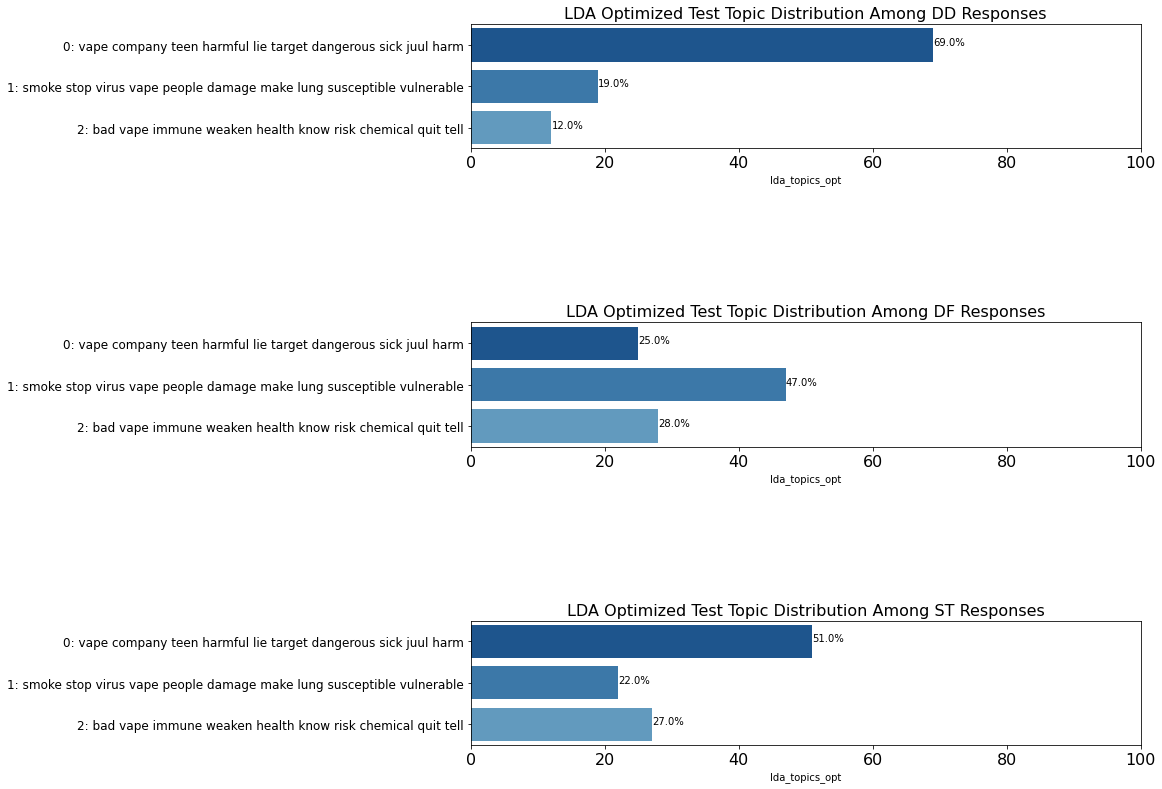

In [14]:
#View topic distributions - LDA Optimized Test
plt.figure(figsize=(12,16))

#DD
plt.subplot(6,1,1)
topic_bars(df_test,'DD','lda_topics_opt','LDA Optimized Test')

#DF
plt.subplot(6,1,3)
topic_bars(df_test,'DF','lda_topics_opt','LDA Optimized Test')

#ST
plt.subplot(6,1,5)
topic_bars(df_test,'ST','lda_topics_opt','LDA Optimized Test')
plt.show()

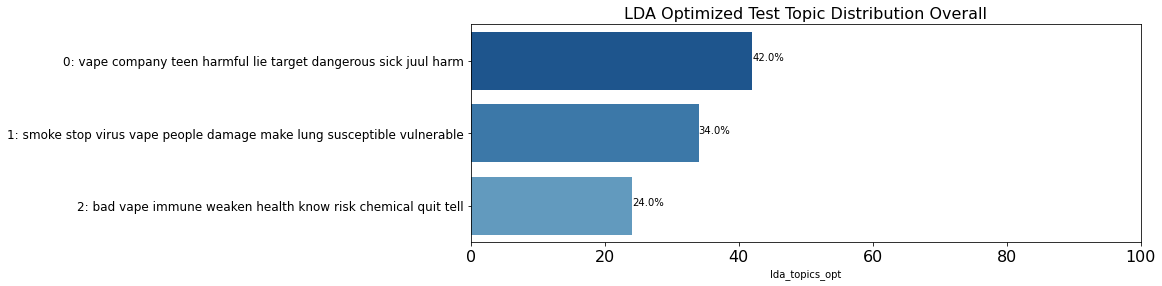

Ad Distribution
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


In [15]:
#Overall
plt.figure(figsize=(12,4))
lda_x = round(df_test['lda_topics_opt'].value_counts(normalize=True).sort_index(),2)*100
lda_y = lda_x
sns.set_palette("Blues_r")
ax = sns.barplot(x=lda_x, y=lda_y.index)

for p in ax.patches:
    percentage = '{:.1f}%'.format((p.get_x() + p.get_width() + 0.02))
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.title('LDA Optimized Test Topic Distribution Overall', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=16)
plt.xlim([0,100])

plt.show()
print('Ad Distribution')
print(round(df_test['Ad'].value_counts(normalize=True),2)*100)

In [16]:
#Perplexity score for optimized topic modeling
base_perplexity_lda_opt = lda_model_opt.perplexity(tfidf_test)
print('The perplexity score for the Optimized LDA model on the test set is: '+str(round(base_perplexity_lda_opt, 2)))

The perplexity score for the Optimized LDA model on the test set is: 551.04


In [17]:
print("The % change from the initial LDA perplexity score is: " + str((1124.55-551.04)/1124.55))

The % change from the initial LDA perplexity score is: 0.5099906629318394


In [18]:
#Run pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_opt, tfidf_test, tfidf_vectorizer,mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  37.363982
1      -387.996002  -373.316162       2        1  34.704252
2     -2184.745605   -60.565800       3        1  27.931766, topic_info=         Term       Freq      Total Category  logprob  loglift
28        bad  22.000000  22.000000  Default  30.0000  30.0000
273     smoke  19.000000  19.000000  Default  29.0000  29.0000
281      stop  18.000000  18.000000  Default  28.0000  28.0000
58    company  16.000000  16.000000  Default  27.0000  27.0000
325     virus  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
284     stuff   1.087360   1.331298   Topic3  -5.2767   1.0730
50   chemical   5.006897   9.597449   Topic3  -3.7496   0.6247
319      vape  16.465411  68.699062   Topic3  -2.5591  -0.1531
189      lung   3.687757  11.008319   Topic3  -4.0554   0.1818
34       body   3.095863  10.579579   Topic3  -4.2303   0.0465

[135 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.640941          19
1         2  0.893791     ability
6         1  0.897309      addict
7         1  0.933082    addicted
12        1  0.801499   advertise
...     ...       ...         ...
328       2  1.040297  vulnerable
329       1  0.935384        want
334       2  1.050367        weak
335       3  1.006170      weaken
340       2  0.934258       young

[109 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Notes on Optimized Topic Model - LDA: 
* Optimized LDA Topic Model based on RandomSearchCV parameter selection of 3 topics and 450 iterations seems to have stronger performance.
    <br><br>
    * As with the base model, the topic with the highest LDA topic value was mapped to each response. 
        * DD ad message is related to companies deceiving teens.
             * Topic 0, with the words, 'vape company teen harmful lie target dangerous sick juul harm...' was mapped to 69% of reponses to DD. This is similar to the base model's topic 0.
        * DF ad message is related to vapes making smokers vulnerable to viruses/illnesses.
            * Topic 1, with the words, 'smoke stop virus vape people damage make lung susceptible vulnerable' was mapped to 47% of responses to DF. This is higher than any topic in the base model was mapped to responses for DF.
        * ST ad message is about the dangerous chemicals in vapes.
            * Topic 0 was also mapped to 51% of responses to ST. This one is much different from the base model, especially because the topic with the word 'chemical' is only mapped to 27% of responses to ST in the optimized model. Note, the ST ad does imply that companies are lying about the chemicals in vapes, so that could explain this mapping or perhaps indicate an area of confusion about the ad messaging.
<br><br>
* The intertopic distance map also shows improvement upon the base model with larger topic sizes and more distance between topics.
* Ultimately, there was also an improvement on the perplexity score from 1124.55 for the base model to 551.04 in the optimized model.
<br><br>
* Next step is to develop a base topic model using the NMF topic modeling approach.

## Step 4: Initial Topic Model - NMF<a class="anchor" id="4"></a>

#### NMF 
Nonnegative matrix factorization (NMF) is a dimension reduction method and factor analysis method. Many dimension reduction techniques are closely related to the low-rank approximations of matrices, and NMF is special in that the low-rank factor matrices are constrained to have only nonnegative elements. 
[NMF definition source: Toward Data Science Article -- NMF](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45#:~:text=Non%2DNegative%20Matrix%20Factorization%20)
<br>

Source: NMF topic model code adapted from
[Towards Data Science article posted by Kamil Mysiak](https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28)

In [19]:
#Instantiate NMF Model using the same initial parameters (6 components, 250 max_iter)
nmf_model = NMF(n_components=6, max_iter = 250, random_state=22).fit(tfidf_train)

#Show mapped topics
display_topics(nmf_model, tfidf_feature_names, no_top_words)

Topic 0:
vape harmful dangerous chemical health immune know quit sick effect
Topic 1:
bad chemical lung body health vape thing people know lot
Topic 2:
stop people try body young kid inform encourage put help
Topic 3:
company lie teen target juul product addict young kid people
Topic 4:
smoke harmful dangerous health good cape vulnerable care inform kid
Topic 5:
virus make lung susceptible damage immune body vulnerable weaken fight


In [20]:
#Add topic models to df to review by ad -- training set

#generates topic values 
nmf_topic_values_train = nmf_model.transform(tfidf_train)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_train['nmf_topics'] = nmf_topic_values_train.argmax(axis=1)

#Adds labels to the topic values for readibility
#With final model, may want to translate these into more readable topics
message_remap = {0: '0: vape harmful dangerous chemical health immune know quit sick effect',
1: '1: bad chemical lung body health vape thing people know lot',
2: '2: stop people try body young kid inform encourage put help',
3: '3: company lie teen target juul product addict young kid people',
4: '4: smoke harmful dangerous health good cape vulnerable care inform kid',
5: '5: virus make lung susceptible damage immune body vulnerable weaken fight'   
}
df_train['nmf_topics'] = df_train['nmf_topics'].map(message_remap)

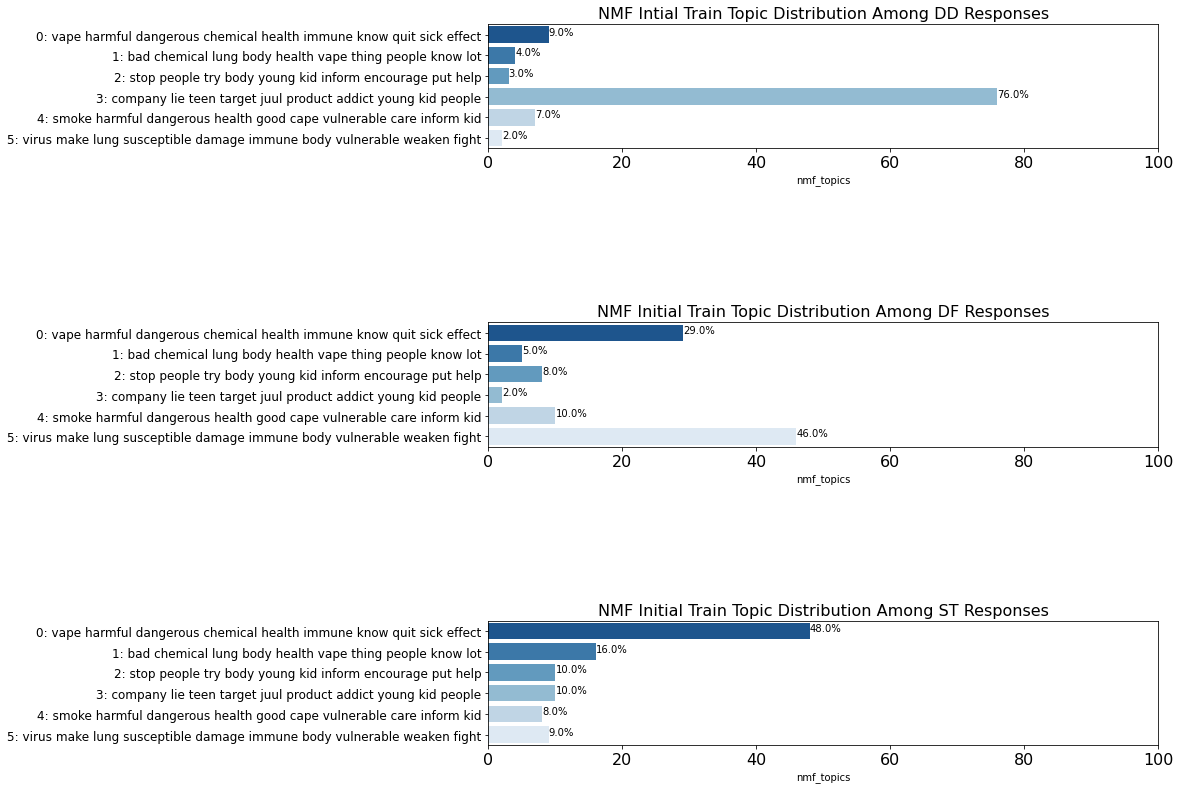

In [21]:
#View topic distributions - NMF Initial Training
plt.figure(figsize=(12,16))

#DD
plt.subplot(6,1,1)
topic_bars(df_train,'DD','nmf_topics','NMF Intial Train')

#DF
plt.subplot(6,1,3)
topic_bars(df_train,'DF','nmf_topics','NMF Initial Train')

#ST
plt.subplot(6,1,5)
topic_bars(df_train,'ST','nmf_topics','NMF Initial Train')
plt.show()

In [22]:
#Add topic models to df to review by ad -- test set

#generates topic values 
nmf_topic_values_test = nmf_model.transform(tfidf_test)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_test['nmf_topics'] = nmf_topic_values_test.argmax(axis=1)

df_test['nmf_topics'] = df_test['nmf_topics'].map(message_remap)

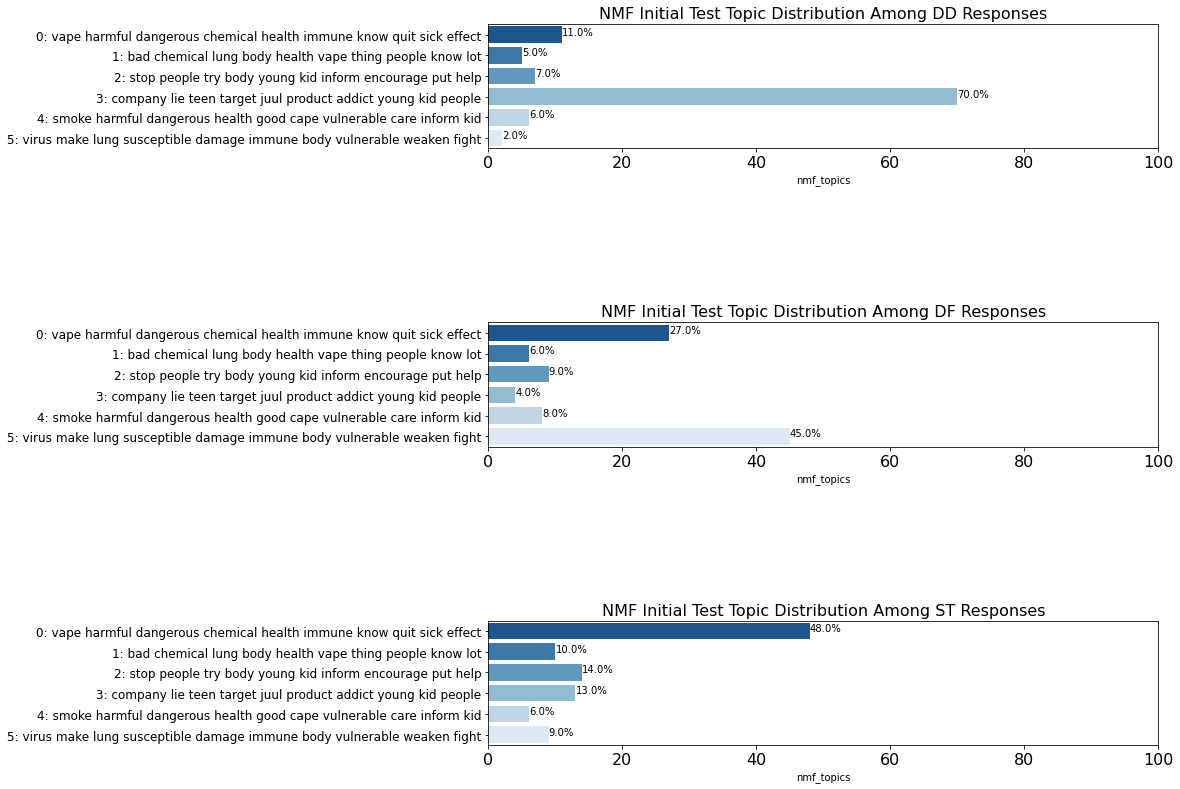

In [23]:
#View topic distributions - NMF Initial Test
plt.figure(figsize=(12,16))

#DD
plt.subplot(6,1,1)
topic_bars(df_test,'DD','nmf_topics','NMF Initial Test')

#DF
plt.subplot(6,1,3)
topic_bars(df_test,'DF','nmf_topics','NMF Initial Test')

#ST
plt.subplot(6,1,5)
topic_bars(df_test,'ST','nmf_topics','NMF Initial Test')
plt.show()

### Notes: 
*NMF Topic Modeling is more subjective as (at least) the sklearn model does not have any scoring method
* Still the Initial NMF Topic Model appears to perform well and runs very quickly.
    * For each response in the testing data set, the topic with the highest NMF topic value was mapped to the response. The percentage of responses to each ad that were mapped to each topic were calculated. 
        * DD ad message is related to companies deceiving teens.
            * Topic 3, with the words, 'company lie teen target juul addict...' was mapped to 70% of reponses to DD. This is a great mapping and very similar to the LDA model.
        * DF ad message is related to vapes making smokers vulnerable to viruses/illnesses.
            * Topic 5 with words 'virus make lung susceptible damage immune body vulnerable weaken fight' was mapped to 45% of responses for DF. This is also a good mapping, but to less than 50% of responses to DF, so could be improved.
        * ST ad message is about the dangerous chemicals in vapes.
            * Topic 0 with words ' vape harmful dangerous chemical health immune know quit sick effect' was mapped to 48% of responses for that ad. This is an improvement over both LDA models (at least subjectively).
        * Topics 1 and 2 were not highly mapped to any of the ads.
<br><br>
* Next step will be to conduct hyperparameter tuning to identify ideal values for:
    * The number of topics (n_components)
    * The maximum number of iterations or loops through the corpus (max_iter)

## Step 5: Hyperparameter Tuning - NMF<a class="anchor" id="5"></a>

#### Random Search for Hyperparameter Tuning<br>
Selecting random search for hyperparameter tuning for its speed and ability to identify ideal parameter values nearly as well as GridSearch.

* The same parameters will be optimized for the NFM Topic Model to ensure comparability between NMF and LDA:
    * n_components: Number of topics to generate
        * Will test range from 1 topic per ad to 4 topics per ad (3-12)
    * max_iter: Number of iterations through the corpus
        * Range from every 50 to 500 (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)

In [24]:
#Create parameter grid
param_grid = { 'n_components': [3,4,5,6,7,8,9,10,11,12],
             'max_iter': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}

#Intantiate NMF model with default parameters
nmf_model = NMF(random_state=22)

#Create function for running random search
#Function code adapated from: https://youtu.be/c_6cJSTuUBY
def hypertuning_rscv(nmf_model, param_grid, iterations, X):
    rdm_search = RandomizedSearchCV(lda_model, param_distributions=param_grid, n_jobs=-1, n_iter=iterations, cv=5)
    
    #Fit
    rdm_search.fit(X)
    max_params = rdm_search.best_params_
    max_score = rdm_search.best_score_
    return max_params, max_score

#50 iterations to search 50% of parameter space (50 iterations / (10 components * 10 iters))
nmf_params, nmf_score = hypertuning_rscv(nmf_model, param_grid, 50, tfidf_train)

In [26]:
#Get results
print('Based on random search, the best parameters for the NMF model are: ' + str(nmf_params))

Based on random search, the best parameters for the NMF model are: {'n_components': 3, 'max_iter': 450}


In [27]:
#Run model again with optimization

#Instantiate NMF Model using the same initial parameters (6 components, 250 max_iter)
nmf_model_opt = NMF(n_components=3, max_iter = 450, random_state=22).fit(tfidf_train)

#Show mapped topics
display_topics(nmf_model_opt, tfidf_feature_names, 10)

Topic 0:
vape company harmful virus lie teen stop immune damage dangerous
Topic 1:
bad vape chemical health smoke lung body thing know lot
Topic 2:
smoke stop people health kid try good inform dangerous teen


In [28]:
#Add optimized topics to df to review by ad -- test set

#generates topic values 
nmf_topic_values_test_opt = nmf_model_opt.transform(tfidf_test)

#Adds topics to each response in df as 'lda_topics' based on max score for topic
df_test['nmf_topics_opt'] = nmf_topic_values_test_opt.argmax(axis=1)

#Adds labels to the 'lda_topics' values for readibility
#With final model, may want to translate these into more readable topics
message_remap = {0: '0: vape company harmful virus lie teen stop immune damage dangerous',
                1: '1: bad vape chemical health smoke lung body thing know lot',
                2: '2: smoke stop people health kid try good inform dangerous teen'}

df_test['nmf_topics_opt'] = df_test['nmf_topics_opt'].map(message_remap)

<Figure size 864x1152 with 0 Axes>

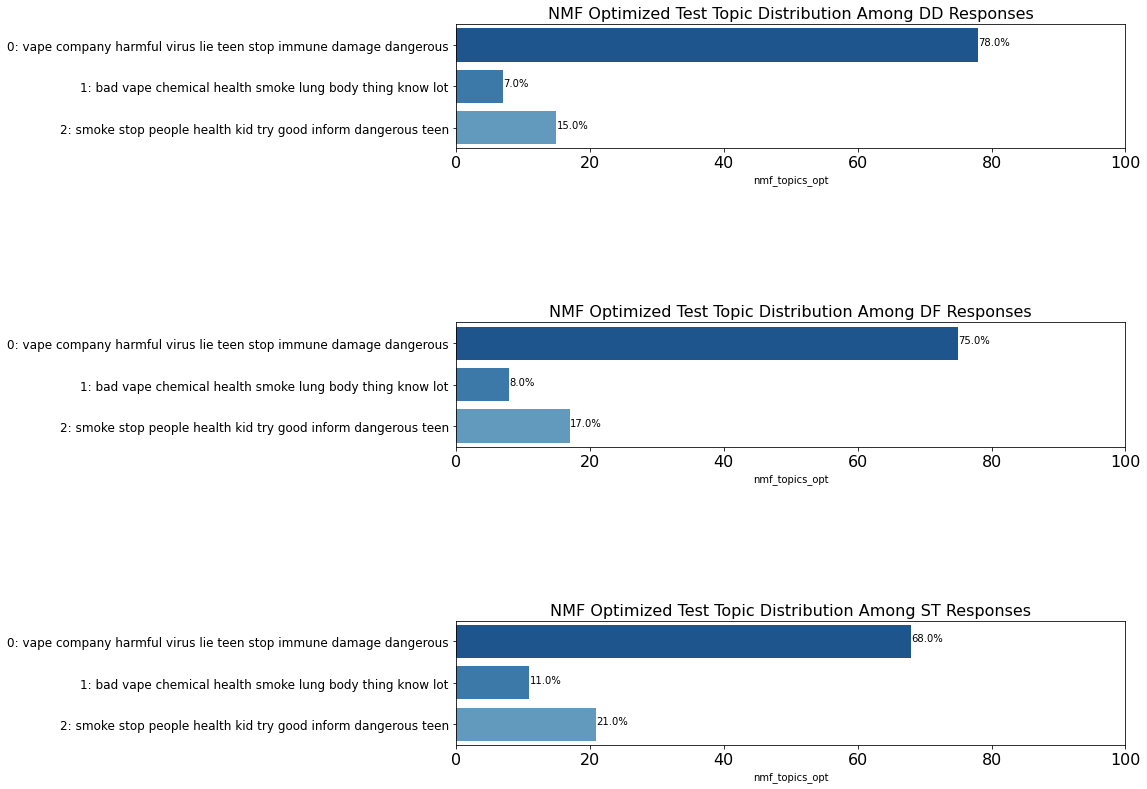

In [29]:
#View topic distributions - LDA Optimized Test
plt.figure(figsize=(12,16))

#View topic distributions - NMF Optimized Test
plt.figure(figsize=(12,16))

#DD
plt.subplot(6,1,1)
topic_bars(df_test,'DD','nmf_topics_opt','NMF Optimized Test')

#DF
plt.subplot(6,1,3)
topic_bars(df_test,'DF','nmf_topics_opt','NMF Optimized Test')

#ST
plt.subplot(6,1,5)
topic_bars(df_test,'ST','nmf_topics_opt','NMF Optimized Test')
plt.show()

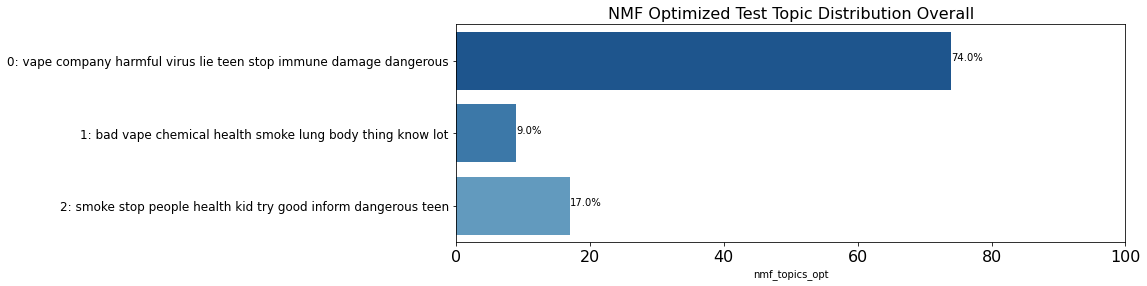

Ad Distribution
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


In [30]:
#Overall
plt.figure(figsize=(12,4))
lda_x = round(df_test['nmf_topics_opt'].value_counts(normalize=True).sort_index(),2)*100
lda_y = lda_x
sns.set_palette("Blues_r")
ax = sns.barplot(x=lda_x, y=lda_y.index)

for p in ax.patches:
    percentage = '{:.1f}%'.format((p.get_x() + p.get_width() + 0.02))
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.title('NMF Optimized Test Topic Distribution Overall', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=16)
plt.xlim([0,100])

plt.show()

plt.show()
print('Ad Distribution')
print(round(df_test['Ad'].value_counts(normalize=True),2)*100)

### Notes on Optimized Topic Model - NMF: 
* Optimized NMF Topic Model based on RandomSearchCV parameter selection of 3 topics and 450 iterations did not perform well.
    <br><br>
    * 74% of responses overall were mapped to just one topic which means there was likely a lot of overlap between topics and topic 0 could be parsed out into another topic.
    * A majority (>66%) of responses to each ad were mapped to topic 0. While topic 0 may apply losely to each of the ads, it is not the best fit as there were better mappings with the optimized LDA model.
    * Using the optimized NMF model could result in erroneously assuming ad messaging comprehension was low for ST and DF.


## Step 6: Final Model Selection<a class="anchor" id="6"></a>
* Based on the results of the modeling for the base models and optimized model, the optimal model for the ad feedback topic model is the <strong>Optimized LDA Model</strong> with 3 topics and 450 iterations.
    * The optimized LDA model mapped well to each of the ads with 69% of responses to DD mapped to topic 0, 47% of responses to DF mapped to Topic 1  and 51% of responses to ST mapped to Topic 0 and 27% mapped to topic 2.
    * Topic 0 was the largest topic with 42% of responses being mapped to it, followed by topic 1 (34%) and topic 2 (24%).
    * The topics was also well distanced from one another based on the intertopic distance map which indicates their boundaries are appropriate with little overlap.
    * The optimized LDA model also had a 51% improvement in perplexity score from the base model.